In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})
current_palette = sns.color_palette()

In [4]:
import sys
PATH_ = '/om/user/rishir/lib/PongRnn/'
sys.path.insert(0, PATH_)
from rnn_analysis import utils, rnn_analysis_utils, data_utils

import numpy as np
import pickle as pk
import pandas as pd
from glob import glob
from scipy.stats import pearsonr

figoutpath = '/om/user/rishir/figs/mpong/rnn_dynamics/'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
df, df_model, df_primate = data_utils.load__comparison_summary_df()

/om/user/rishir/lib/PongRnn/rnn_analysis/data_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['regularization_weight'][t] = 0
/om/user/rishir/lib/PongRnn/rnn_analysis/data_utils.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['regularization_loss'][t] = 'none'


In [6]:
def plot_full_piecewise_gradient(res_gradient_decode, outfn=None, 
                                 vmin=0, vmax=1, f=None, axes=None):
    x = np.array(res_gradient_decode['R2_over_bins']['r2_over_bins'])
    xticks = np.unique(np.array(res_gradient_decode['bin_results']['centers'])[:,0])
    yticks = np.unique(np.array(res_gradient_decode['bin_results']['centers'])[:,1])

    extent = [np.nanmin(xticks), np.nanmax(xticks), 
              np.nanmin(yticks), np.nanmax(yticks), 
             ]
    
    n = int(x.shape[0]**0.5)
    x = np.reshape(x, (n,n))
    if f is None:
        f,axes = plt.subplots(1,1,figsize=(5,5))
    h = axes.imshow(x.T, cmap="viridis", 
                    interpolation='none',
                    vmin=vmin, vmax=vmax, origin='lower')
    axes.contour(x.T, levels=2, colors='w', alpha=0.5)
    occ_idx = np.nonzero(xticks >= 24.0)[0][0]
    axes.axvline(occ_idx, color='w')
    xx = list(range(xticks.shape[0]))
    xn = int(n/4)
    axes.set_xticks(xx[::xn])
    axes.set_xticklabels(xticks[::xn])
    axes.set_yticks(xx[::xn])
    axes.set_yticklabels(yticks[::xn])


    f.colorbar(h, ax=axes)
    axes.set_xlim([0,n])
    axes.set_ylim([0,n])
    plt.tight_layout()
    if outfn is not None:
        f.savefig('%s/%s.pdf' % (figoutpath, outfn))
        print('Saved to %s/%s.pdf' % (figoutpath, outfn))
    return
    
    
def plot_dist(res_mean):
    N = len(res_mean.keys())
    f,axes = plt.subplots(1,N,figsize=(2.5*N,3))
    for fki,fk in enumerate(res_mean.keys()):
        ax = axes[fki]
        bplot = ax.boxplot(np.array(res_mean[fk]), 
                   whis=3, notch=True, patch_artist=True);
        for bp in bplot['boxes']:
            bp.set_facecolor([0.6, 0.6, 0.6])
        for bp in bplot['medians']:
            bp.set_color([0.2, 0.2, 0.2])
        ax.plot([1,2], np.nanmedian(res_mean[fk], axis=0), 
                 lw=2, color='k');
        ax.set_ylim([0,0.75])
        ax.set_xlim([0.75,2.25])
        sns.despine(ax=ax, offset=10, trim=False)
    plt.tight_layout()
    return f

def plot_maps(res, bin_results, colorvar=None, use_median=True):
    N = len(res.keys())
    def summary_func(x):
        if use_median:
            return np.nanmedian(x,axis=0)
        else:
            return np.nanmean(x,axis=0)
        
    if colorvar is not None:
        vmin = np.nanpercentile(summary_func(res[colorvar]), 1)
        vmax = np.nanpercentile(summary_func(res[colorvar]), 99)
    else:
        vmin, vmax = 0,1
    f,axes = plt.subplots(1,N, figsize=(5*N,5))

    for li, lwt in enumerate(res.keys()):
        res_dat_new = {
        'R2_over_bins':{
            'r2_over_bins':summary_func(res[lwt])
        },
        'bin_results': bin_results,
        }
        plot_full_piecewise_gradient(res_dat_new, vmin=vmin, vmax=vmax, 
                                     f=f, axes=axes[li])
        axes[li].set_title(lwt)
    plt.tight_layout()
    return f

def get_pixel_data():
    fn = '/om/user/rishir/lib/MentalPong/dat/gradient_axis/gradmap_nb32bs2output_vis-sim_pixels'
    dat = pk.load(open(fn, 'rb'))
    XX = dat['R2_over_bins']['r2_over_bins']
    return np.expand_dims(XX, axis=0)

def get_meta_null():
    fn = '/om/user/rishir/lib/MentalPong/dat/gradient_axis/gradmap_nb32bs2output_vis-sim_meta_null'
    dat = pk.load(open(fn, 'rb'))
    XX = dat['R2_over_bins']['r2_over_bins']
    return np.expand_dims(XX, axis=0)


def plot_map_marginals(res, use_median=True):
    
    def summary_func(x):
        if use_median:
            return np.nanmedian(x,axis=0)
        else:
            return np.nanmean(x,axis=0)
    
    def bootstrapped_summary_metric(x, nboot=100):
        n = x.shape[0]
        X_bootdist = []
        for bi in range(nboot):
            idx = np.random.choice(n, n, replace=True)
            X_bootdist.append(summary_func(x[idx,:]))
        mu = np.nanmean(X_bootdist, axis=0)
        sig = np.nanstd(X_bootdist, axis=0)
        return mu, sig
    
    def get_summary_metric_from_map(x):
        n = int(x.shape[1]**0.5)
        X2 = np.reshape(x, (X.shape[0],n,n))
        Xm = np.nanmean(X2, axis=2) # average over y
        return bootstrapped_summary_metric(Xm) # dist over models
        
    def shaded_errorbar(x,y,yerr, ax):
        ax.plot(x, y, 'k:')
        ax.fill_between(x, y-yerr, y+yerr, alpha=0.5)
        return

    f,axes = plt.subplots(1,1, figsize=(5,4))
    for fk in ['mov', 'sim-mov', 'vis-mov','vis-sim-mov',]:
        X = np.array(res[fk])
        mu, sig = get_summary_metric_from_map(X)
        shaded_errorbar(range(mu.shape[0]), mu, sig, axes)
        
    X = get_meta_null()
    mu, sig = get_summary_metric_from_map(X)
    shaded_errorbar(range(mu.shape[0]), mu, sig, axes)
        
    X = get_pixel_data()
    mu, sig = get_summary_metric_from_map(X)
    shaded_errorbar(range(mu.shape[0]), mu, sig, axes)
    
    axes.set_xlim([0,mu.shape[0]])
    axes.axvline(24, color='k')
    axes.set_xlabel('x pos')
    axes.set_ylabel('R^2')
    sns.despine(ax=axes, offset=10, trim=False)
    plt.tight_layout()
    return f


In [7]:
prefix = '/om/user/rishir/lib/MentalPong/dat/gradient_axis/'
def get_results_split_by_conditions(query_key, query_options, suffix, query_str=None):
    # get models associated with each loss type
    fns_per_conds = {}
    res_per_conds = {}
    res_mu_per_conds = {}
    
    res_fn = glob('%s/%s*.pkl' % (prefix, suffix))[0]
    res_dat_example = pk.load(open(res_fn, 'rb'))
    bin_results = res_dat_example['bin_results']
    
    if query_str is None:
        query_str = 'rnn_type != "none"'

    for qc in query_options:
        tmp = '%s == "%s"' % (query_key, qc)
        fns = df_model.query(tmp).query(query_str)['filename']
        fns_per_conds[qc] = [fn.split('/')[-1] for fn in fns]

    for qc in query_options:
        fns = fns_per_conds[qc]
        res_per_conds[qc] = []
        res_mu_per_conds[qc] = []
        for fn in fns:
            res_fn = '%s/%s%s' % (prefix, suffix, fn)
            res_dat = pk.load(open(res_fn, 'rb'))
            x = np.array(res_dat['R2_over_bins']['r2_over_bins'])
            res_per_conds[qc].append(x)

            n = int(x.shape[0]**0.5)
            x_ = np.reshape(x, (n,n))
            n2 = int(n*0.75)
            mean_tmp = [np.nanmean(x_[:n2,:]), np.nanmean(x_[n2:,:])]
            res_mu_per_conds[qc].append(mean_tmp)
    
    summary_results = {
        'res_per_conds': res_per_conds,
        'res_mu_per_conds': res_mu_per_conds,
        'fns_per_conds': fns_per_conds, 
        'bin_results': bin_results,
    }
    
    return summary_results

default_lw_options = ['mov', 'vis-sim-mov', 'vis-mov', 'sim-mov']
def plot_results_split_by_conditions(suffix, query_key='loss_weight_type', 
                                    query_options=default_lw_options, 
                                    query_str=None):
    
    res_full = get_results_split_by_conditions(query_key, query_options, suffix)
    for use_median in [False]:
        f1 = plot_maps(res_full['res_per_conds'], res_full['bin_results'], colorvar='vis-sim-mov', use_median=use_median)
        f2 = plot_map_marginals(res_full['res_per_conds'], use_median)
        
        outfn = '%s/maps_f1_%s_%d.pdf' % (figoutpath, suffix, use_median)
        f1.savefig(outfn)
        outfn = '%s/maps_f2_%s_%d.pdf' % (figoutpath, suffix, use_median)
        f2.savefig(outfn)
        
    return res_full

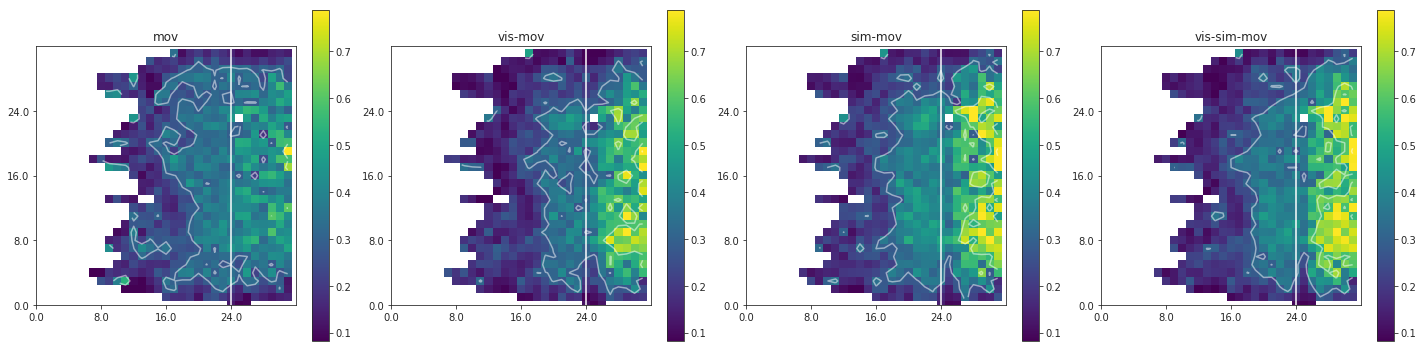

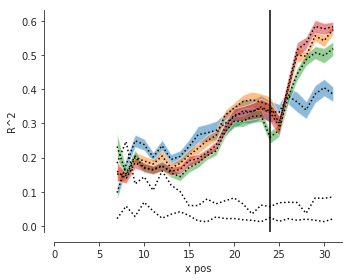

In [8]:
query_key = 'loss_weight_type'
query_options = ['mov',  'vis-mov', 'sim-mov', 'vis-sim-mov']
suffix = 'gradmap_nb32bs2output_vis-sim_'
res_32_2 = plot_results_split_by_conditions(suffix, query_key=query_key, query_options=query_options)

In [9]:
def plot_2d_scatter(df_model, cmetric_fn, 
                    xmetric_fn='decode_vis-sim_to_sim_index_mae_k2',
                    ymetric_fn='error_f_mae'):
    
    rx,px = pearsonr(df_model[xmetric_fn], df_model[cmetric_fn])
    ry,py = pearsonr(df_model[ymetric_fn], df_model[cmetric_fn])
    f,axes = plt.subplots(1,1,figsize=(6,5))
    tmp_df = df_model.sort_values(cmetric_fn)
    
    vmin = np.nanpercentile(df_model[cmetric_fn], 1)
    vmax = np.nanpercentile(df_model[cmetric_fn], 99)

    tmp = axes.scatter(tmp_df[xmetric_fn], tmp_df[ymetric_fn], 
                       c=tmp_df[cmetric_fn], s=50+tmp_df[cmetric_fn]*100,
                       cmap="viridis", vmin=vmin, vmax=vmax,
                       edgecolors='k')
    axes.set_xlabel('%s\nr=%2.2f,p=%2.2e'%(xmetric_fn,rx,px))
    axes.set_ylabel('%s\nr=%2.2f,p=%2.2e'%(ymetric_fn,ry,py))
    f.colorbar(tmp, label=cmetric_fn)

    axes.set_xlim([5,0])
    axes.set_ylim([4,0])
    # axes.set_aspect(1.0)

    sns.despine(ax=axes, offset=10, trim=False)
    plt.tight_layout()
    f.savefig('%s/scatter2d_%s.pdf' % (figoutpath, cmetric_fn))
    
def plot_jittered_scatter(fks, outfn_suffix=None, query_str=None):
    if query_str is not None:
        data_df = df_model.query(query_str)
    else:
        data_df = df_model
    f,axes = plt.subplots(1,1,figsize=(2*len(fks),6))
    ax = axes
    xvariance=0.1
    for fki, fk in enumerate(fks):
        xval_1 = np.squeeze(np.random.randn(df_model.shape[0],1)*xvariance + fki)
        sns.scatterplot(data=data_df, x=xval_1, y=fk,
                        hue="loss_weight_type", style="rnn_type", 
                        alpha=0.5, ax=axes, legend=False);
        
    df_model.groupby('loss_weight_type')[fks].mean().T.plot(ax=axes, lw=3, zorder=1)
    sns.despine(ax=axes, offset=10, trim=False)
    axes.set_xlim([-0.5, fki+0.5])
    axes.set_ylabel('R^2')
    axes.set_title(outfn_suffix)
    plt.tight_layout()
    if outfn_suffix is not None:
        f.savefig('%s/%s.pdf' % (figoutpath, outfn_suffix))
    return

In [11]:
df_model['mean_gradient_coding_r2_nb_vis'] = np.nan
df_model['mean_gradient_coding_r2_nb_occ'] = np.nan
df_model['mean_gradient_coding_r2_vis'] = np.nan
df_model['mean_gradient_coding_r2_occ'] = np.nan

for dfi in range(df_model.shape[0]):
    fn = df_model['filename'][dfi]
    lwt = df_model['loss_weight_type'][dfi]
    fn_suffix = fn.split('/')[-1]
    
    idx = res_32_2['fns_per_conds'][lwt].index(fn_suffix)
    mu_v_o = res_32_2['res_mu_per_conds'][lwt][idx]
    df_model['mean_gradient_coding_r2_vis'][dfi] = mu_v_o[0]
    df_model['mean_gradient_coding_r2_occ'][dfi] = mu_v_o[1]

/home/rishir/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/rishir/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


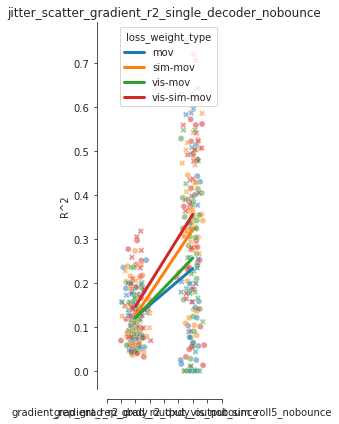

In [12]:
fks = ['gradient_rep_grad_r2_dxdy_output_vis_nobounce', 'gradient_rep_grad_r2_dxdy_output_sim_roll5_nobounce']
plot_jittered_scatter(fks, outfn_suffix='jitter_scatter_gradient_r2_single_decoder_nobounce')


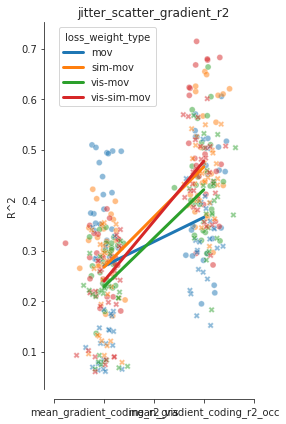

In [13]:
fks = ['mean_gradient_coding_r2_vis', 'mean_gradient_coding_r2_occ']
plot_jittered_scatter(fks, outfn_suffix='jitter_scatter_gradient_r2')


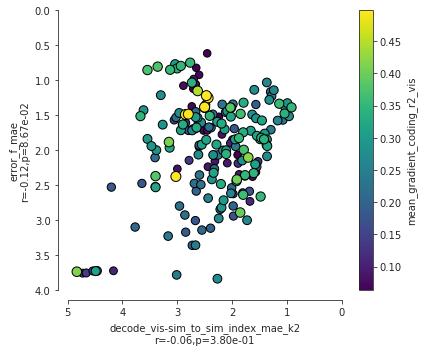

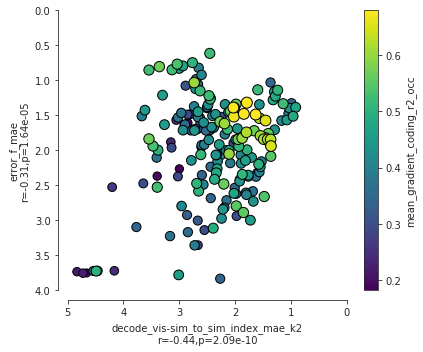

In [14]:
plot_2d_scatter(df_model, 'mean_gradient_coding_r2_vis')
plot_2d_scatter(df_model, 'mean_gradient_coding_r2_occ')